# menginstall library yang dibutuhkan

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.6 MB/s eta 0:00:00


In [ ]:
!pip install pandas scikit-learn numpy


# Import library

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

# function preprocessing dengan Sastrawi dan NLTK

In [ ]:
import nltk

In [ ]:
!pip install Sastrawi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.7 MB/s eta 0:00:00


In [ ]:
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove special characters and punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize the text (split into words)
    words = text.split()

    # Initialize stemmer and stopword remover
    stemmer = StemmerFactory().create_stemmer()
    stopword_remover = StopWordRemoverFactory().create_stop_word_remover()

    # Apply stemming and stopword removal to each word
    processed_words = []
    for word in words:
        # Stemming
        word = stemmer.stem(word)
        # Stopword removal
        word = stopword_remover.remove(word)
        # Append processed word
        if len(word) > 1:  # Filter out single characters
            processed_words.append(word)

    # Join the processed words back into a single string
    processed_text = ' '.join(processed_words)

    return processed_text

In [ ]:
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text_NLTK(text):
    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Stopword removal
    indonesian_stopwords = set(stopwords.words('indonesian'))
    tokens = [token for token in tokens if token.lower() not in indonesian_stopwords]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Joining tokens back to a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text


# load data

load data keseluruhan kurang lebih 5000 Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

# Unzip training set
local_zip = '/content/drive/MyDrive/Colab Notebooks/Copy of modelGabung_lokal.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./labeledGabungan_appsLokal')

zip_ref.close()

load data hanya yang grab AppStore terlabeli untuk menguji model terhadap data grab Appstore

# split data

In [ ]:
df_texts = pd.read_csv('/content/tokopedia_playstore_test_texts.csv', header=0, parse_dates=[0], index_col=0)
df_labels = pd.read_csv('/content/tokopedia_playstore_test_labels.csv', header=0, parse_dates=[0], index_col=0)

In [ ]:
df_texts['content']

521    Asw di keterangan pengiriman tidak di cantumka...
737    Freeongkir nya udh gk bisa bersatu sama cashba...
740    proses cepat..membantu. bunga ga terlalu mhal ...
660    kerenn buat pengguna baru dapat flas sale 1000...
411    Tolong ongkir nya bisa lebih di ringankan lagi...
                             ...                        
408    Jujur agak ribet tahapannya dibanding yg lain,...
332    Ongkirnya aneh samajuga bohong, percuma dpt gr...
208                                             Ok punya
613                      belajar jadi lebih menyenangkan
78                               untuk sekarang masih ok
Name: content, Length: 200, dtype: object

In [ ]:
df_labels['sentiment']

521    2
737    2
740    1
660    1
411    1
      ..
408    2
332    0
208    1
613    1
78     0
Name: sentiment, Length: 200, dtype: int64

In [ ]:
import numpy as np
sentiment_counts = np.bincount(df_labels['sentiment'].tolist())

# Print the counts
for sentiment_label, count in enumerate(sentiment_counts):
    print(f"Sentiment {sentiment_label}: {count} occurrences")

Sentiment 0: 20 occurrences
Sentiment 1: 66 occurrences
Sentiment 2: 114 occurrences


In [ ]:
df_labels['sentiment'] = df_labels['sentiment'].replace(0, 3)
df_labels['sentiment'] = df_labels['sentiment'].replace(1, 0)
df_labels['sentiment'] = df_labels['sentiment'].replace(2, 1)
df_labels['sentiment'] = df_labels['sentiment'].replace(3, 2)

In [ ]:
import numpy as np
sentiment_counts = np.bincount(df_labels['sentiment'].tolist())

# Print the counts
for sentiment_label, count in enumerate(sentiment_counts):
    print(f"Sentiment {sentiment_label}: {count} occurrences")

Sentiment 0: 66 occurrences
Sentiment 1: 114 occurrences
Sentiment 2: 20 occurrences


In [ ]:
test_texts = df_texts['content'].apply(preprocess_text)
test_texts = df_texts['content'].apply(preprocess_text_NLTK)
test_labels = df_labels['sentiment']

# Melakukan tokenisasi

In [ ]:
test_texts = [str(text) for text in test_texts]


In [ ]:
test_encodings = tokenizer.batch_encode_plus(test_texts, truncation=True, padding=True, return_tensors='pt')
test_labels = torch.tensor(test_labels.tolist())


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# membuat dataLoader untuk training dan test data

In [ ]:
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

# menggunakan indo bert model

In [ ]:
output_dir = '/content/labeledGabungan_appsLokal/content/Model_gabungan'
# Set the device to 'cuda' if a GPU is available, otherwise 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model and tokenizer from the saved directory
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Move the model to the specified device
model.to(device)

# Now you can proceed with the inference code you provided

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
predictions = []
true_labels = []

# Deactivate gradient calculation for inference
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)

        # Get predicted labels
        _, predicted_labels = torch.max(outputs.logits, dim=1)

        predictions.extend(predicted_labels.detach().cpu().numpy())
        true_labels.extend(labels.detach().cpu().numpy())

# Convert the predictions and true labels into numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")

# Generate classification report
target_names = ['positive', 'negative','neutral']
classification_rep = classification_report(true_labels, predictions, target_names=target_names)
print(classification_rep)

Accuracy: 0.2962962962962963
              precision    recall  f1-score   support

    positive       1.00      0.24      0.39        82
    negative       0.80      0.36      0.50        22
     neutral       0.05      1.00      0.10         4

    accuracy                           0.30       108
   macro avg       0.62      0.54      0.33       108
weighted avg       0.92      0.30      0.40       108



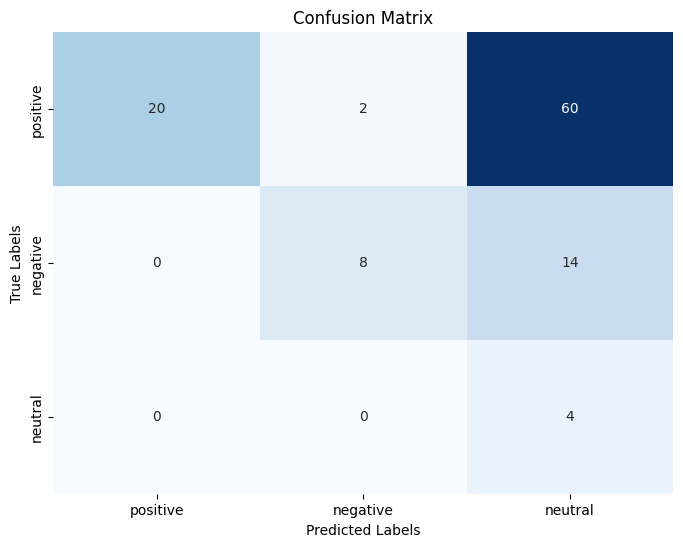

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
confusion_mat = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
predictions = []
true_labels = []

# Deactivate gradient calculation for inference
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)

        # Get predicted labels
        _, predicted_labels = torch.max(outputs.logits, dim=1)

        predictions.extend(predicted_labels.detach().cpu().numpy())
        true_labels.extend(labels.detach().cpu().numpy())

# Convert the predictions and true labels into numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")

# Generate classification report
target_names = ['positive', 'negative','neutral']
classification_rep = classification_report(true_labels, predictions, target_names=target_names)
print(classification_rep)

Accuracy: 0.42
              precision    recall  f1-score   support

    positive       0.74      0.42      0.54        66
    negative       0.85      0.39      0.53       114
     neutral       0.11      0.60      0.18        20

    accuracy                           0.42       200
   macro avg       0.56      0.47      0.42       200
weighted avg       0.74      0.42      0.50       200



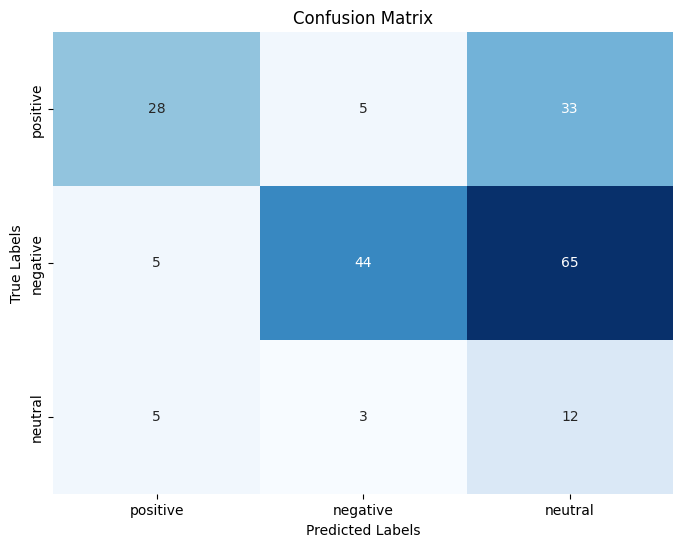

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
confusion_mat = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
